# Data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from statistics import mean

## Constants

In [2]:
# PATHS
PROJECT_PATH=".."
DATA_PATH=f"{PROJECT_PATH}/data"
FIGURES_PATH=f"{PROJECT_PATH}/results/figures"
# scripts_path=f"{project_path}/scripts"

# I     # Frist ID
n=16    # number of items
N=100   # number of instances
m=0.8   # ratio of capacity/total_weight
W=5000  # max weight of an item 
w="bal" # more light or heavy items, or balanced
C=5000  # max value of an item
c="uni" # weith,value correlation
k=1     # granularity exponent

NS_VALUES=[1, 4, 7, 10, 13, 16, 19, 22, 25, 28] # [1, 4, 7, 10, 13, 16, 19, 22, 23, 26] # [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
MS_VALUES=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
BIG_WS_VALUES=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
WS_VALUES=["bal", "light", "heavy"]
BIG_CS_VALUES=[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
CS_VALUES=["uni", "corr", "strong"]
KS_VALUES=[["light", "heavy"], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]
PS_VALUES=[0,1,2,3,4,5,6,7,8,9]


## Parameter Test

In [3]:
class ParamTest:
    figures_path=f"{PROJECT_PATH}/results/figures/test"
    inst_suffix  = "inst.csv"
    sol_suffix  = "sol.csv"
    
    methods = {"1":"bf", "2":"bab", "3":"dp", "4":"gh", "5":"redux"}
    
    inst_columns = ["ID", "n", "W", "weights", "values", "max_value"]
    sol_columns = ["ID", "n", "max_value", "solution", "time", "error", "method"]
    stats_columns = ["n", "N", "m", "W", "w", "C", "c", "k", "time_max", "time_mean", "error_max", "error_mean"]
#     columns = [self.name, "mean_time", "max_time", "mean_error", "max_error", "method"]


    def __init__(self, params, values, path):
        self.params = params if (isinstance(params, list) and isinstance(params[0], str)) else [params]
        self.values = values if (isinstance(values, list) and isinstance(values[0], list)) else [values]
        self.path = path
        
        self.inst_df = pd.DataFrame(columns=self.inst_columns)
        self.sol_df = pd.DataFrame(columns=self.sol_columns)
        self.stats_df = pd.DataFrame(columns=self.stats_columns)
        
        self.loadInstances()
        self.loadSolutions()

        self.calculateMaxValue()
        self.calulateMeanWeightAndValue()
        self.calculateRelativeError()
        self.loadStats()


    def __repr__(self):
        return f"ParamTest - self.params: {self.params}, self.path: {self.path}, self.values:{self.values}"


    def appendInstDataframe(self, in_file, **kwargs):
        df = pd.read_csv(in_file, sep=' ', header=None)

        df.columns = [str(x) for x in df.columns]
        df = df.rename(columns = {"0": "ID", "1": "n", "2": "W"})
        df["weights"] = df.apply(lambda x: list(x[df.columns[3::2]]), axis=1)
        df["values"] = df.apply(lambda x: list(x[df.columns[4::2]]), axis=1)
        df = df.drop(df.columns[3:-2], axis=1)
        
        for key, value in kwargs.items():
            df[key] = value

        self.inst_df = pd.concat([self.inst_df, df])

        
    def loadInstances(self):
        for p in product(*[self.params[-1:], *self.values, [self.inst_suffix]]):
            inst_file = f"{self.path}/{'_'.join([str(i) for i in p])}"
#             print(inst_file)
            params_len = len(self.params)
#             kwargs = dict(zip(p[: params_len], p[params_len : (params_len+len(self.values))]))
            kwargs = dict(zip(self.params, p[1 : (1+len(self.values))]))
#             print("kwargs: ", kwargs)
            self.appendInstDataframe(inst_file, **kwargs)

    
    
    def appendSolDataframe(self, tmp_file, **kwargs):
        df = pd.read_csv(tmp_file, sep=' ', header=None)
        
        df.columns = [str(x) for x in df.columns]
        df = df.rename(columns = {"0": "ID", "1": "n", "2": "max_value", df.columns[-1]: "time"})
        df["solution"] = df.apply(lambda x: list(x[df.columns[3:3+df["n"][0]]]), axis=1)
        df = df.drop(df.columns[3:-2], axis=1)
        
        for key, value in kwargs.items():
            df[key] = value

        self.sol_df = pd.concat([self.sol_df, df])
        
        
    def loadSolutions(self):
        for p in product(*[self.params[-1:], self.methods.values(), *self.values, [self.sol_suffix]]):
            sol_file = f"{self.path}/{'_'.join([str(i) for i in p])}"
#             print(sol_file)
            params_len = len(self.params)
            kwargs = dict(zip(["method", *self.params], p[1 : (1+1+len(self.values))]))
#             kwargs = dict(zip(["method", *p[: params_len]], p[params_len : (params_len+1+len(self.values))]))
#             print("kwargs: ", kwargs)
            self.appendSolDataframe(sol_file, **kwargs)

#         for num, met in self.methods.items():
#                 self.dfs[f"{self.name}_{met}_{value}"] =\
#                     getMethodResults(f"{data_path}/{self.dataset}/{self.name}_{met}_{value}_sol.csv")
#                 self.dfs[f"{self.name}_{met}_{value}"]["error"] =\
#                     self.dfs[f"{self.name}_{met}_{value}"][["ID","max_value"]].apply(
#                         lambda row: calculateRelativeError(self.dfs[f"{self.name}_bf_{value}"], row), axis=1
#                     )

    def calulateMeanWeightAndValue(self):
        self.inst_df["mean_weight"] = self.inst_df["weights"].apply(mean)
        self.inst_df["mean_value"] = self.inst_df["values"].apply(mean)

    def calculateMaxValue(self):
        flawless_method = "bf"
        self.inst_df["max_value"] = self.sol_df[self.sol_df["method"] == flawless_method]["max_value"]
        
    def calculateRelativeError(self):
        
        def getMaxValue(self, x):
            param_filter = self.inst_df["ID"] == x["ID"]
            for param in self.params:
                param_filter = param_filter & (self.inst_df[param] == x[param])
            
            return self.inst_df[param_filter]["max_value"].values[0]
            
        
        def calculate(max_value, computed_value):
#             print("max value", max_value, "computed_value", computed_value)
            difference = abs(max_value - computed_value)
            max_value = max(max_value, computed_value)
            assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
            rel_error = difference/max_value if (max_value > 0) else 0
            return rel_error            
        
#         id_filter = (self.inst_df["ID"] == x["ID"])
#         param_filter = (self.inst_df[self.params[0]] == x[self.params[0]])

        self.sol_df["error"] = self.sol_df.apply(lambda x: 
            calculate(getMaxValue(self, x), x["max_value"]), axis=1)


#         self.sol_df["error"] = self.sol_df.apply(lambda x: 
#             calculate(self.inst_df[
#                 (self.inst_df["ID"] == x["ID"]) & (self.inst_df[self.params[-1]] == x[self.params[-1]])
#             ]["max_value"].values[0], x["max_value"]), axis=1)
        
        
#     def calculateRelativeError(df_sol, row):
#         difference = abs(df_sol[df_sol["ID"] == row["ID"]]["max_value"].values[0] - row["max_value"]) 
#         max_value = max(df_sol[df_sol["ID"] == row["ID"]]["max_value"].values[0], row["max_value"])
#         assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
#         rel_error = difference/max_value if (max_value > 0) else 0
#         return rel_error

    def loadStats(self):
        df = self.sol_df.copy()

        df = df[[*self.params, "method", "time", "error"]].groupby(["method", *self.params])
        df = df.agg(['mean', 'max'])
        # df.columns = df.columns.to_flat_index()
        df.columns = [f"{col[0]}_{col[1]}" for col in df.columns]
        # df = df["method"].unstack()

        # df = df.stack()
        df = df.reset_index()
        # df["level_2"].unstack()
        # df = df.rename(columns={"level_2": "aggregation"})

        self.stats_df = df

    
    def loadDf(self):
        self.loadInstances()
        self.loadSolutions()

    def seeHistogram(self, feature, method, **values):
        hist_filter = self.sol_df["method"] == method
        for key, value in values.items():
            hist_filter = hist_filter & (self.sol_df[key] == value)

        ax = sns.distplot(self.sol_df[hist_filter][feature], kde=False, label=str(values))
        ax.set_title(f"{feature.capitalize()} histogram, method: {method}, params: {values}")
        
        for label in ax.get_xticklabels():
            label.set_rotation(45)
        
        fig = ax.get_figure()
        fig_name = f"hist_{feature}_{method}_{'_'.join([f'{k}_{v}' for k,v in values.items()])}".replace(".", "")
        fig.savefig(f"{self.figures_path}/{fig_name}.png")
        
#         sns.distplot(self.sol_df[
#             (self.sol_df["method"] == method) & (self.sol_df[self.params[0]] == value)
#         ][feature], kde=False)        

    
    def seeTimeHistogram(self, method, **values):
        self.seeHistogram("time", method, **values)
    
    def seeErrorHistogram(self, method, **values):
        self.seeHistogram("error", method, **values)


    def seeBarplot(self, feature):
        df = self.stats_df
        if len(self.params) == 1:
            g = sns.FacetGrid(df, col="method", sharey=False)
        else:
            g = sns.FacetGrid(df, col="method", row=self.params[0], sharey=False)
        g.map(sns.barplot, self.params[-1], f"{feature}_max", color="firebrick", order=self.values[-1], label="max")
        g.map(sns.barplot, self.params[-1], f"{feature}_mean", color="tab:blue", order=self.values[-1], label="mean")
        
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(45)
        plt.legend()
        g.savefig(f"{self.figures_path}/{self.params[-1]}_{feature}.png")
        
    
    def seeTimeBarplot(self):
        self.seeBarplot("time")

    def seeErrorBarplot(self):
        self.seeBarplot("error")

        
    def seeBoxplot(self, feature, method, **values):
        param_filter = self.sol_df["method"] == method
        for key, value in values.items():
            param_filter = param_filter & (self.sol_df[key] == value)

        fig = sns.boxplot(y=self.params[-1], x=feature, orient="h" ,data=self.sol_df[param_filter])
#         fig.savefig(f"{self.figures_path}/{self.params[-1]}_{feature}.png"))

    def seeBoxplotFull(self, feature):
        df = self.sol_df
        if len(self.params) == 1:
            g = sns.FacetGrid(df, col="method", sharey=False)
        else:
            g = sns.FacetGrid(df, col="method", row=self.params[0], sharey=False)
            
        meanprops={"marker":"o", "markerfacecolor":"white", 
            "markeredgecolor":"black","markersize":"10"}
        
        g.map(sns.boxplot, self.params[-1], feature, order=self.values[-1], showmeans=True, meanprops=meanprops)
        
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(45)
        g.savefig(f"{self.figures_path}/boxplot_{self.params[-1]}_{feature}.png")
        
    def seeTimeBoxplot(self, method, **values):
        self.seeBoxplot("time", method, **values)
        
    def seeErrorBoxplot(self, method, **values):
        self.seeBoxplot("error", method, **values)

## Number of Items

- bf - exponencial, robust
- bab - exponencial, robust
- dp - polynomial, robust
- gh - linear, 

In [4]:
data_ns = ParamTest("n", path=f"{PROJECT_PATH}/data_old/ns", values=NS_VALUES)

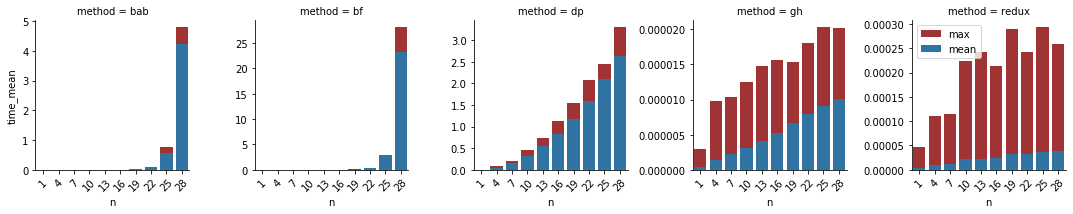

In [5]:
data_ns.seeTimeBarplot()

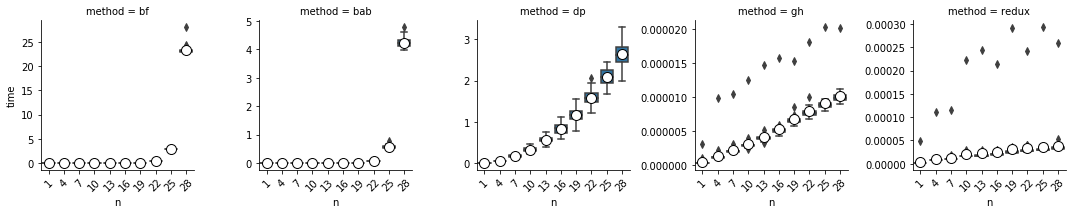

In [6]:
data_ns.seeBoxplotFull("time")

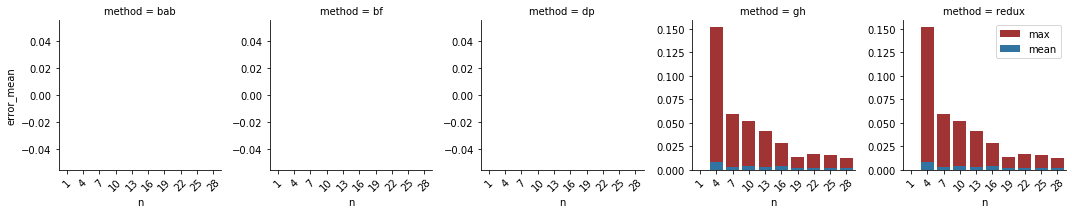

In [7]:
data_ns.seeErrorBarplot()

## Capacity / Total Items Weight

In [8]:
data_ms = ParamTest("m", path=f"{DATA_PATH}/ms", values=MS_VALUES)

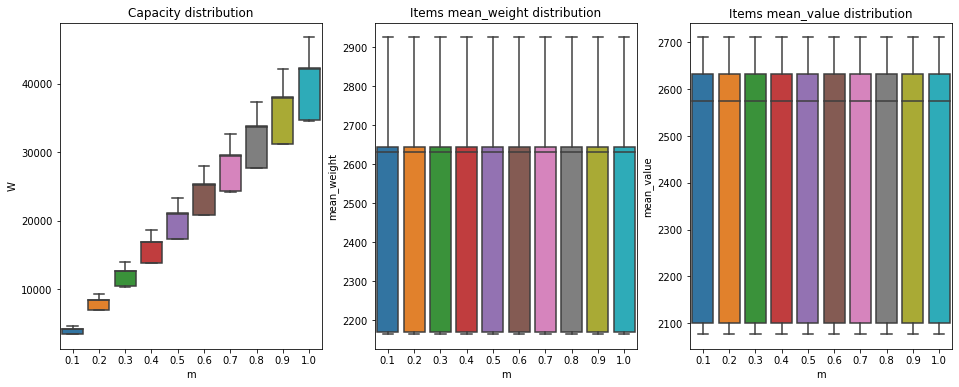

In [9]:
df = data_ms.inst_df
feature="m"

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(16, 6)

axes[0].set_title(f"Capacity distribution")
sns.boxplot(x=feature, y="W", data= df, ax=axes[0])

axes[1].set_title(f"Items mean_weight distribution")
sns.boxplot(x=feature, y="mean_weight", data= df, ax=axes[1])

axes[2].set_title(f"Items mean_value distribution")
ax = sns.boxplot(x=feature, y="mean_value", data= df, ax=axes[2])

plt.savefig(f"{data_ms.figures_path}/distributions_capacity_total_weight_ratio.png")

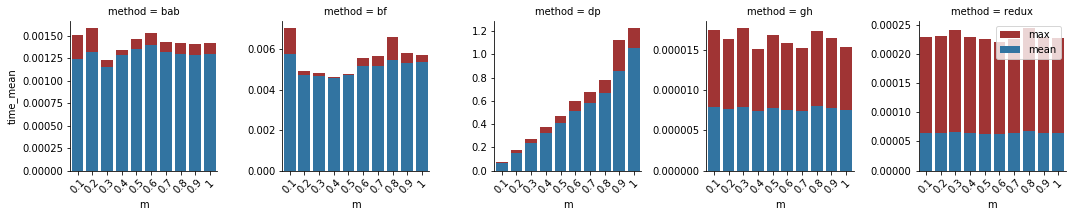

In [10]:
data_ms.seeTimeBarplot()

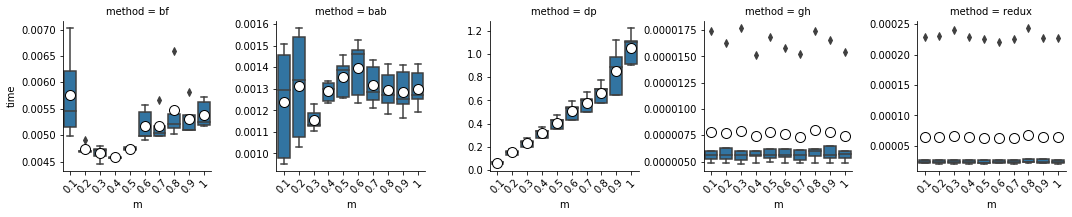

In [11]:
data_ms.seeBoxplotFull("time")

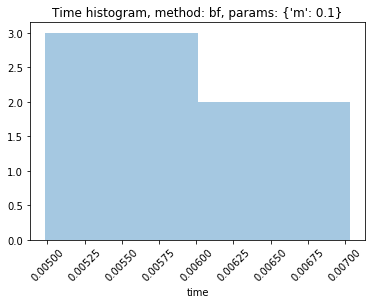

In [12]:
data_ms.seeTimeHistogram(method="bf", m=0.1)

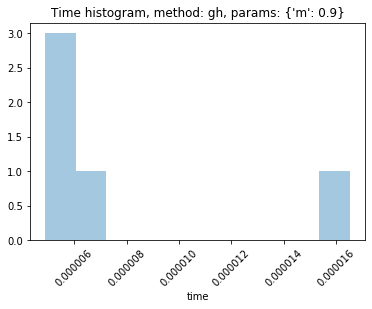

In [13]:
data_ms.seeTimeHistogram(method="gh", m=0.9)

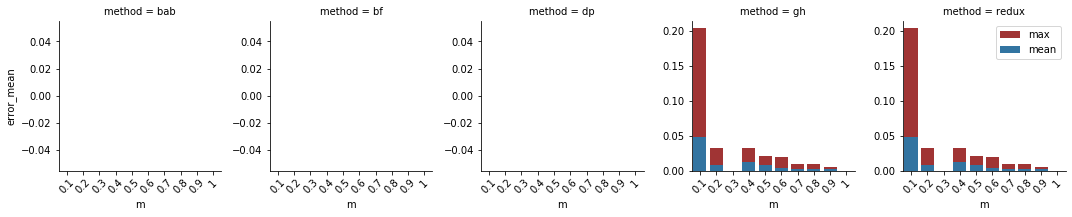

In [14]:
data_ms.seeErrorBarplot()

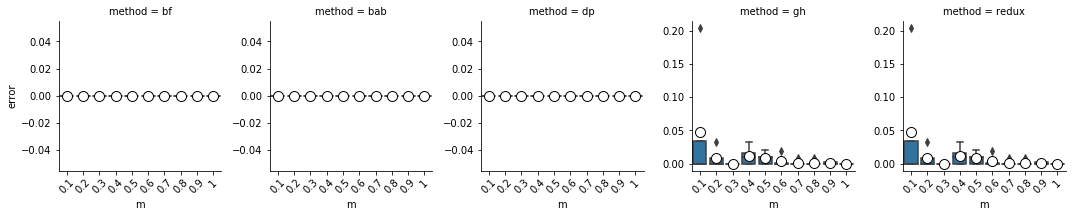

In [15]:
data_ms.seeBoxplotFull("error")

## Value/Weight Correlation

In [16]:
data_cs = ParamTest("c", path=f"{DATA_PATH}/cs", values=CS_VALUES)

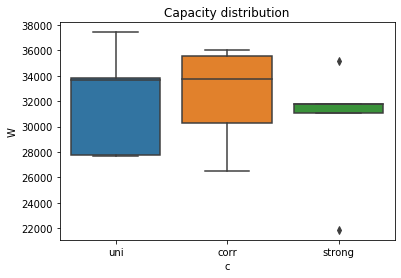

In [17]:
df = data_cs.inst_df
feature="c"



ax = sns.boxplot(x=feature, y="W", data= df)
ax.set_title(f"Capacity distribution")


plt.savefig(f"{data_ms.figures_path}/capacity_distributions_value_weight_corr.png")
plt.show()


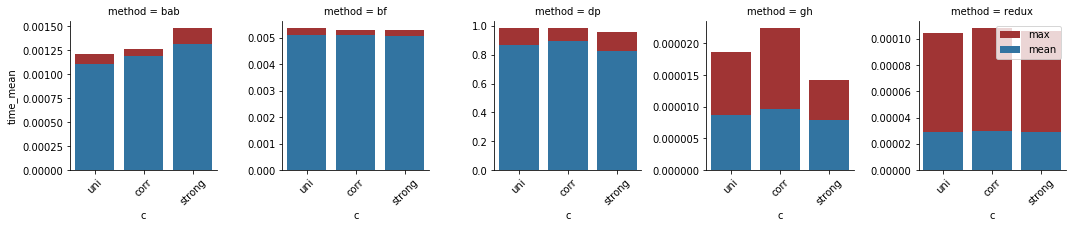

In [18]:
data_cs.seeTimeBarplot()

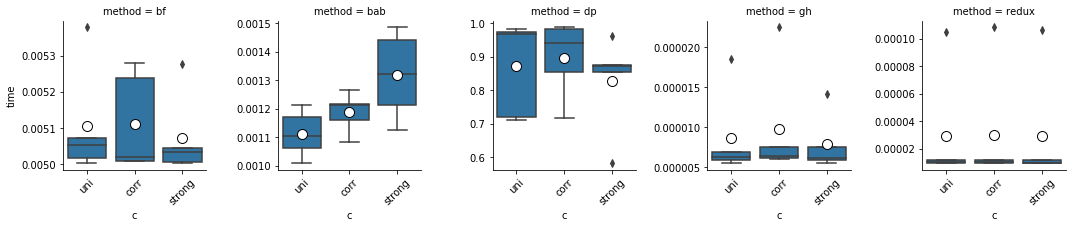

In [19]:
data_cs.seeBoxplotFull("time")

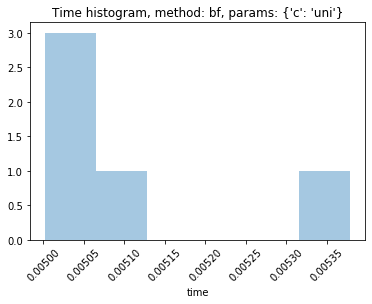

In [20]:
data_cs.seeTimeHistogram(method="bf", c="uni")

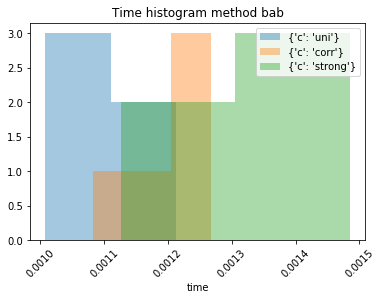

In [21]:
data_cs.seeTimeHistogram(method="bab", c="uni")
data_cs.seeTimeHistogram(method="bab", c="corr")
data_cs.seeTimeHistogram(method="bab", c="strong")

plt.gca().set_title('Time histogram method bab')
plt.legend()

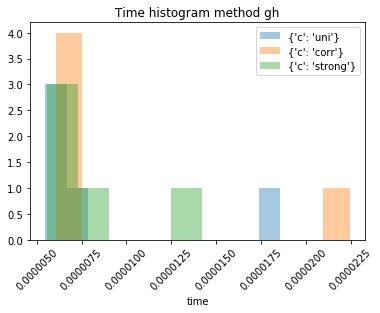

In [22]:
data_cs.seeTimeHistogram(method="gh", c="uni")
data_cs.seeTimeHistogram(method="gh", c="corr")
data_cs.seeTimeHistogram(method="gh", c="strong")

plt.gca().set_title('Time histogram method gh')
plt.legend()

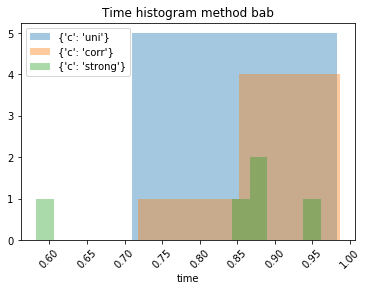

In [23]:
data_cs.seeTimeHistogram(method="dp", c="uni")
data_cs.seeTimeHistogram(method="dp", c="corr")
data_cs.seeTimeHistogram(method="dp", c="strong")

plt.gca().set_title('Time histogram method bab')
plt.legend()

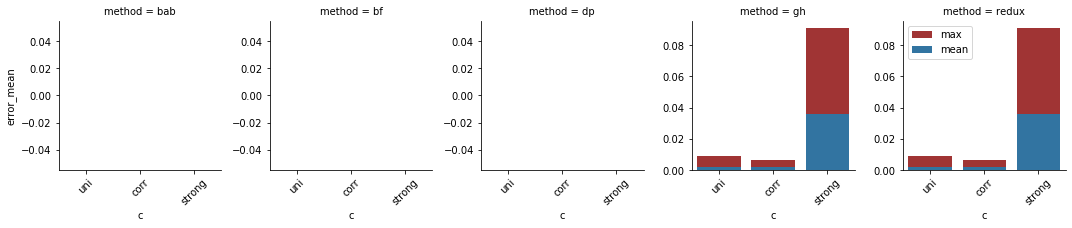

In [24]:
data_cs.seeErrorBarplot()

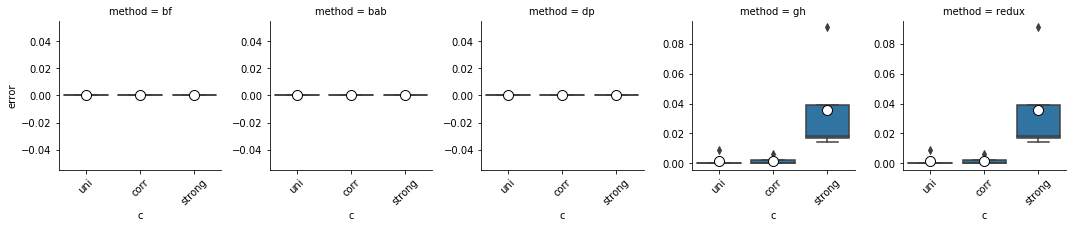

In [25]:
data_cs.seeBoxplotFull("error")

## Weight Distribution

In [26]:
data_ws = ParamTest("w", path=f"{DATA_PATH}/ws", values=WS_VALUES)

In [27]:
df = data_ws.inst_df


df

# arr_bal = []
# for l in df[df["w"] == "bal"]["weights"].values:
#     arr_bal.extend(l)
# sns.distplot(arr_bal, kde=False, label="bal")

# arr_light = []
# for l in df[df["w"] == "light"]["weights"].values:
#     arr_light.extend(l)
# sns.distplot(arr_light, kde=False, label="light")

# arr_heavy = []
# for l in df[df["w"] == "heavy"]["weights"].values:
#     arr_heavy.extend(l)
# sns.distplot(arr_heavy, kde=False, label="heavy")

# plt.legend()
# plt.savefig(f"{data_ws.figures_path}/weight_distributions")

,ID,n,W,weights,values,max_value,w,mean_weight,mean_value
0,1,16,27780,"[718, 858, 4040, 2973, 543, 1080, 2926, 3006, ...","[6, 2257, 187, 4168, 1292, 1474, 599, 1210, 28...",32831,bal,2170.3125,2101.0625
1,2,16,27716,"[2347, 999, 3049, 2005, 441, 3509, 1481, 159, ...","[3652, 2427, 445, 2713, 3999, 2529, 3449, 3282...",41428,bal,2165.3125,2710.5000
2,3,16,37431,"[4681, 4161, 347, 1466, 3702, 4385, 1171, 3372...","[293, 4144, 1766, 3270, 810, 2648, 983, 1707, ...",40762,bal,2924.3125,2632.5000
3,4,16,33692,"[334, 356, 3246, 3539, 1240, 4810, 3032, 2269,...","[1725, 1349, 3168, 3502, 430, 2385, 3713, 3908...",38590,bal,2632.2500,2575.3125
4,5,16,33856,"[1660, 3099, 4522, 873, 537, 684, 2855, 3409, ...","[989, 1750, 1577, 3840, 1647, 2355, 1521, 4090...",30826,bal,2645.0625,2076.6875
0,1,16,26300,"[4283, 833, 2075, 3791, 722, 2175, 2267, 1952,...","[858, 1292, 3006, 2840, 1344, 442, 3297, 2005,...",33095,light,2054.6875,2208.6875
1,2,16,16963,"[2353, 1629, 731, 225, 691, 247, 1755, 1499, 1...","[983, 1487, 4715, 2936, 4161, 2958, 3539, 430,...",41512,light,1325.2500,2725.8750
2,3,16,21646,"[1302, 1672, 95, 3907, 3043, 2489, 370, 1641, ...","[4746, 1608, 3975, 3211, 4662, 4637, 2184, 471...",49921,light,1691.1250,3351.6250
3,4,16,22605,"[1152, 3675, 2733, 1625, 1778, 3382, 1716, 102...","[313, 3185, 3980, 4448, 4592, 3297, 1713, 3206...",43735,light,1766.0625,3022.6875
4,5,16,21179,"[418, 1454, 877, 3234, 968, 2335, 1847, 2360, ...","[828, 1402, 3154, 335, 2794, 2240, 1471, 4905,...",34050,light,1654.6250,2219.3125


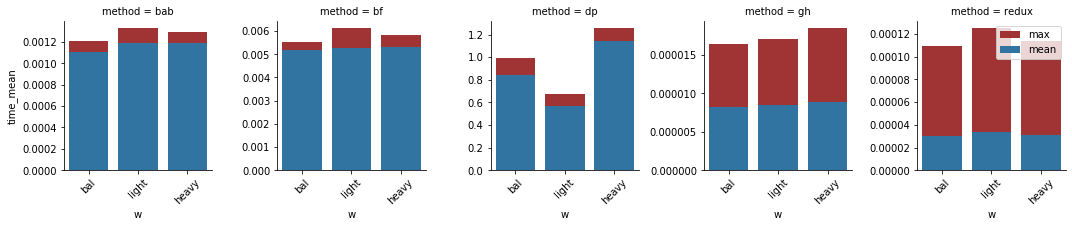

In [29]:
data_ws.seeTimeBarplot()

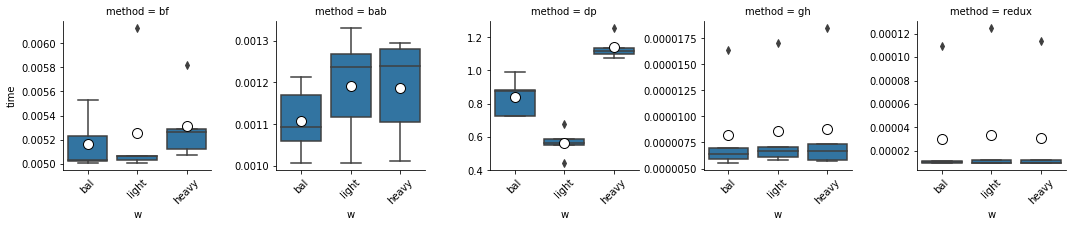

In [30]:
data_ws.seeBoxplotFull("time")

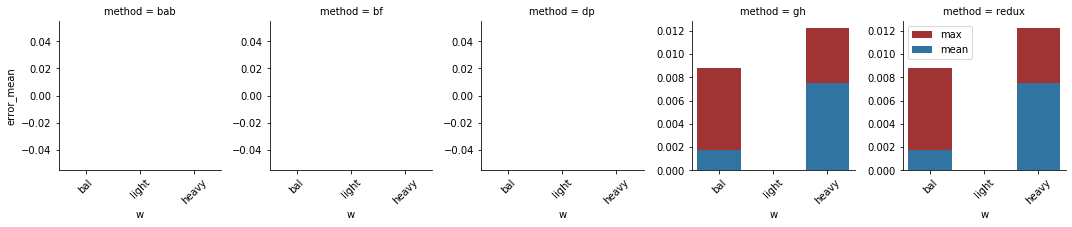

In [31]:
data_ws.seeErrorBarplot()

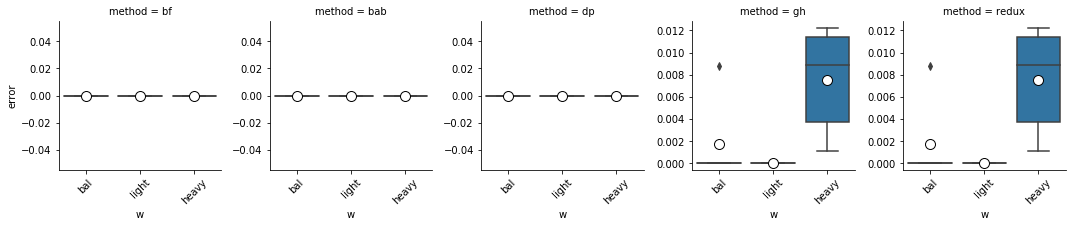

In [32]:
data_ws.seeBoxplotFull("error")

## Granularity

In [33]:
data_ks = ParamTest(["w","k"], path=f"{DATA_PATH}/ks", values=KS_VALUES)

In [34]:
df = data_ks.inst_df

display(
    df[df["w"] == "light"]["W"].min(),
    df[df["w"] == "heavy"]["W"].min()
)

16963

31837

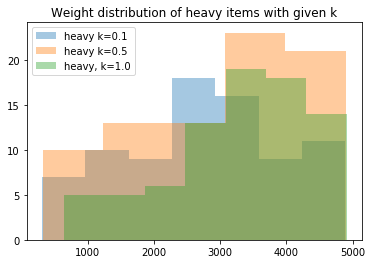

In [35]:
df = data_ks.inst_df

arr_heavy_01 = []
for l in df[(df["w"] == "heavy") & (df["k"] == 0.1)]["weights"].values:
    arr_heavy_01.extend(l)
sns.distplot(arr_heavy_01, kde=False, label="heavy k=0.1")

arr_heavy_05 = []
for l in df[(df["w"] == "heavy") & (df["k"] == 0.5)]["weights"].values:
    arr_heavy_05.extend(l)
sns.distplot(arr_heavy_05, kde=False, label="heavy k=0.5")

arr_heavy = []
for l in df[(df["w"] == "heavy") & (df["k"] == 1)]["weights"].values:
    arr_heavy.extend(l)
ax = sns.distplot(arr_heavy, kde=False, label="heavy, k=1.0")
ax.set_title("Weight distribution of heavy items with given k")

plt.legend()
plt.savefig(f"{data_ws.figures_path}/weight_distributions_with_k")

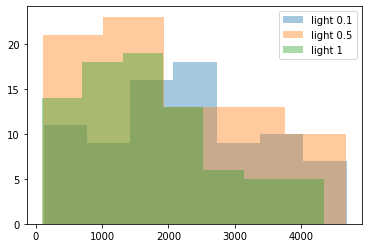

In [36]:
df = data_ks.inst_df

arr_light_01 = []
for l in df[(df["w"] == "light") & (df["k"] == 0.1)]["weights"].values:
    arr_light_01.extend(l)
sns.distplot(arr_light_01, kde=False, label="light 0.1")

arr_light_05 = []
for l in df[(df["w"] == "light") & (df["k"] == 0.5)]["weights"].values:
    arr_light_05.extend(l)
sns.distplot(arr_light_05, kde=False, label="light 0.5")

arr_light = []
for l in df[(df["w"] == "light") & (df["k"] == 1)]["weights"].values:
    arr_light.extend(l)
sns.distplot(arr_light, kde=False, label="light 1")

plt.legend()

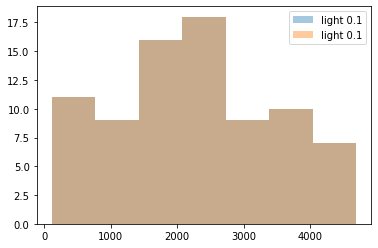

In [37]:
df = data_ks.inst_df

arr_light_01 = []
for l in df[(df["w"] == "light") & (df["k"] == 0.1)]["weights"].values:
    arr_light_01.extend(l)
sns.distplot(arr_light_01, kde=False, label="light 0.1")

arr_light_01 = []
for l in df[(df["w"] == "light") & (df["k"] == 0.1)]["weights"].values:
    arr_light_01.extend(l)
sns.distplot(arr_light_01, kde=False, label="light 0.1")

plt.legend()

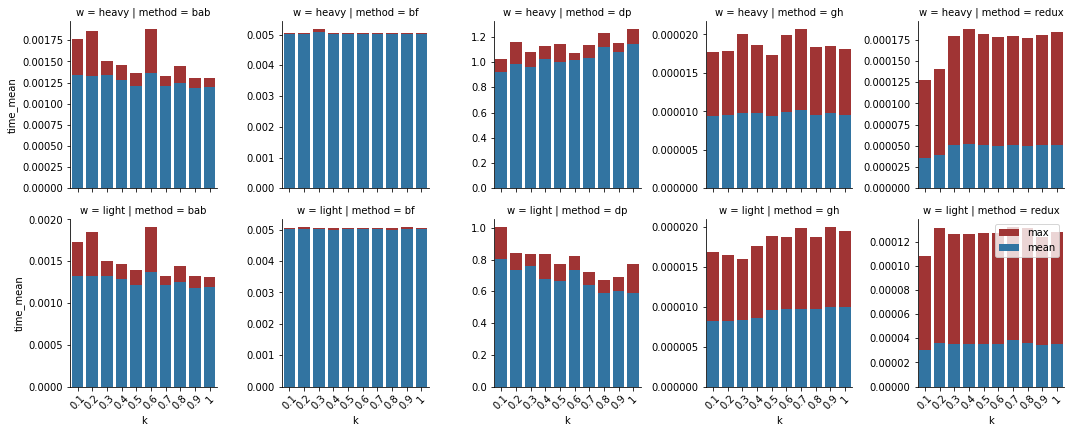

In [38]:
data_ks.seeTimeBarplot()

# data_ks.stats_df

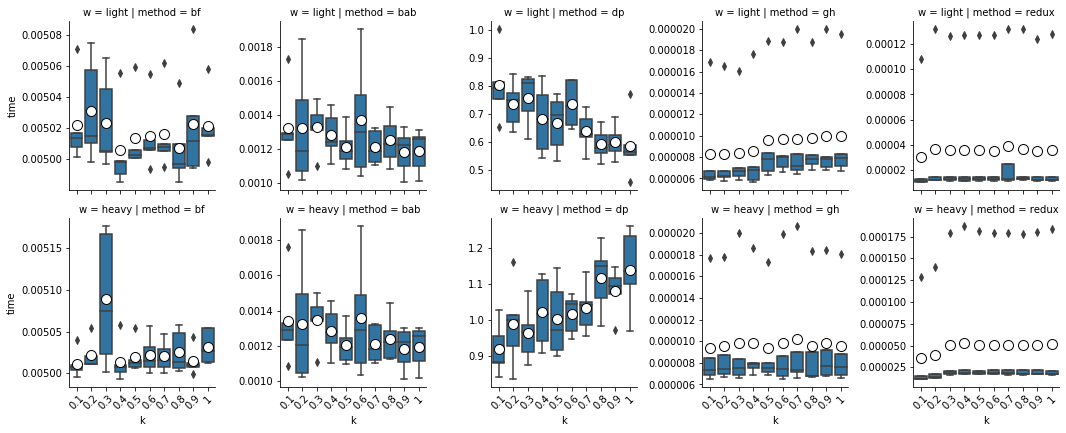

In [39]:
data_ks.seeBoxplotFull("time")

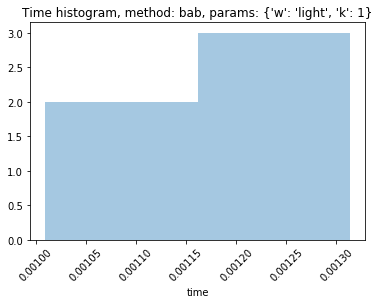

In [40]:
data_ks.seeTimeHistogram(method="bab", w="light", k=1)

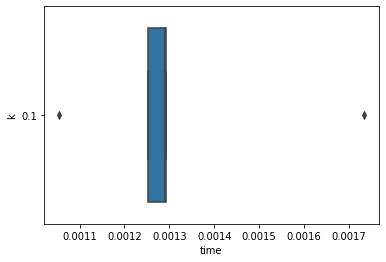

In [41]:
data_ks.seeTimeBoxplot(method="bab", w="light", k=0.1)

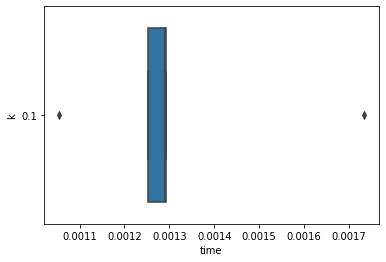

In [42]:
# data_ks.seeTimeHistogram(method="bf", w="light", k=0.2)

self= data_ks

# data_ks.seeTimeHistogram(method="bab", w="light", k=0.1)
method="bab"
feature="time"
values = {
    "w": "light",
    "k": 0.1,
}

param_filter = self.sol_df["method"] == method
for key, value in values.items():
    param_filter = param_filter & (self.sol_df[key] == value)

sns.boxplot(y=self.params[-1], x=feature, orient="h" ,data=self.sol_df[param_filter])

# self.sol_df[param_filter]

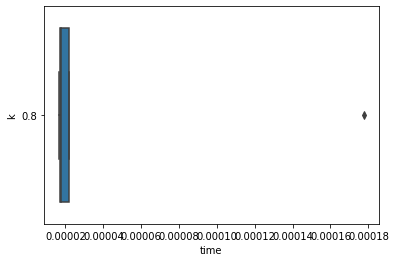

In [43]:
data_ks.seeTimeBoxplot(method="redux", w="heavy", k=0.8)

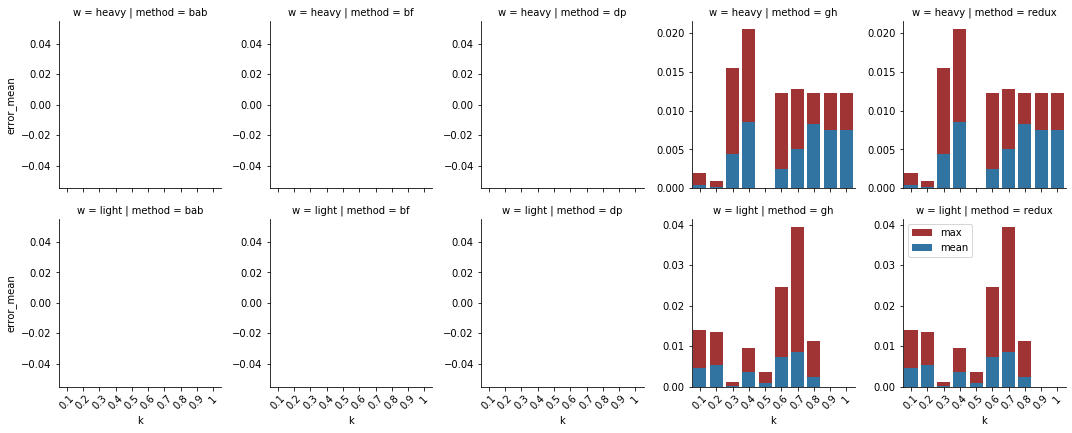

In [44]:
data_ks.seeErrorBarplot()

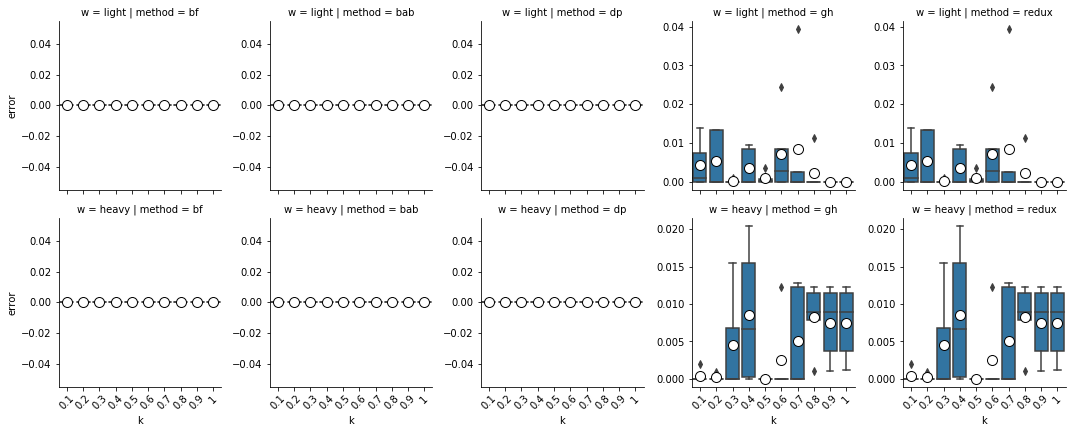

In [45]:
data_ks.seeBoxplotFull("error")

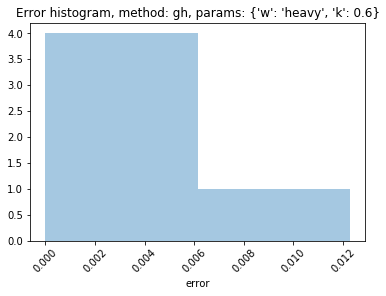

In [46]:
data_ks.seeErrorHistogram(method="gh", w="heavy", k=0.6)

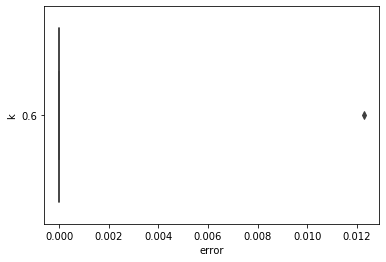

In [47]:
data_ks.seeErrorBoxplot(method="gh", w="heavy", k=0.6)

## Maximum Item Weight

In [48]:
data_Ws = ParamTest(["W"], path=f"{DATA_PATH}/Ws", values=BIG_WS_VALUES)

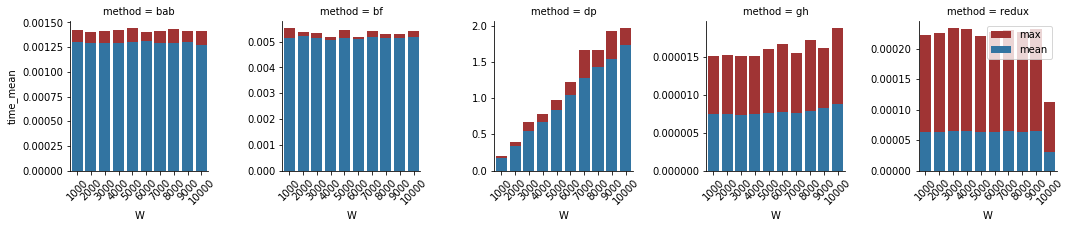

In [49]:
data_Ws.seeTimeBarplot()

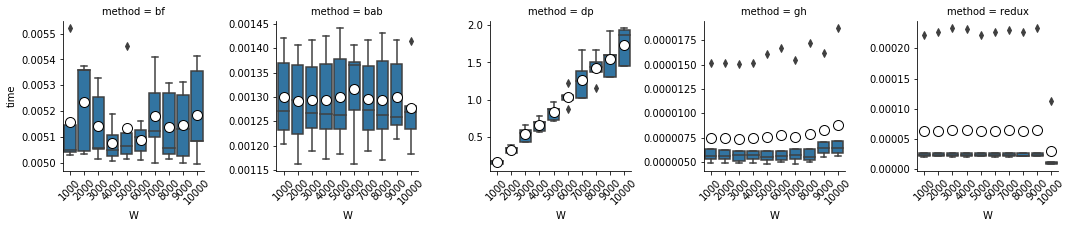

In [50]:
data_Ws.seeBoxplotFull("time")

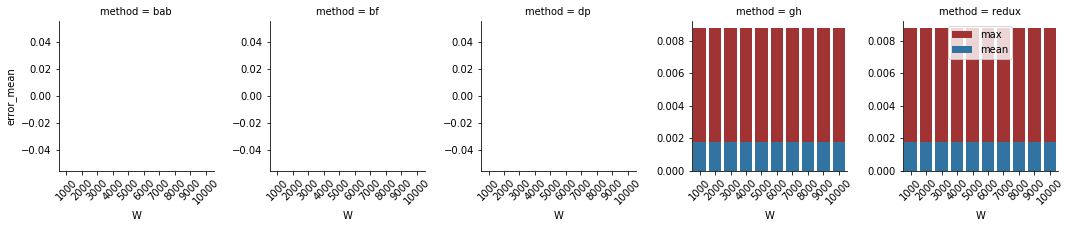

In [51]:
data_Ws.seeErrorBarplot()

## Maximum Item Value

In [52]:
data_Cs = ParamTest(["C"], path=f"{DATA_PATH}/Cs", values=BIG_CS_VALUES)

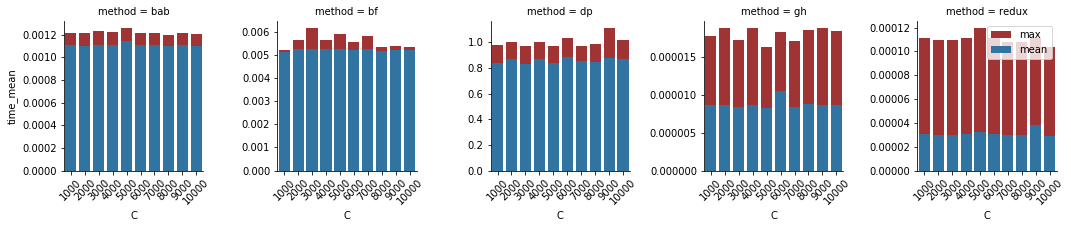

In [53]:
data_Cs.seeTimeBarplot()

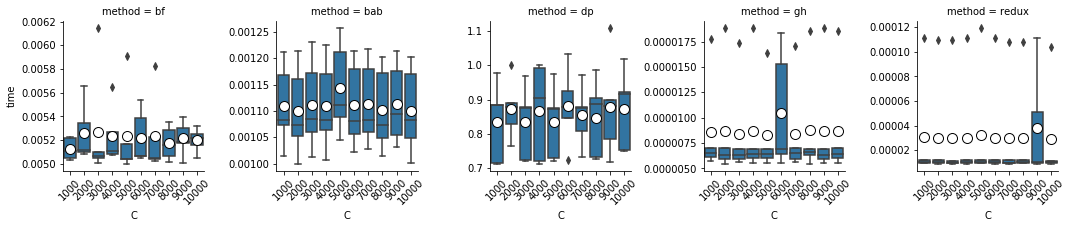

In [54]:
data_Cs.seeBoxplotFull("time")

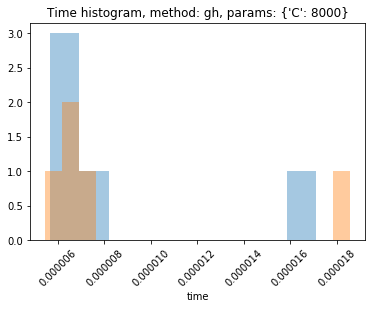

In [55]:
# data_Cs.seeTimeHistogram(method="bf", C=1000)
# data_Cs.seeTimeHistogram(method="bf", C=2000)
# data_Cs.seeTimeHistogram(method="bf", C=3000)
# data_Cs.seeTimeHistogram(method="bf", C=4000)
# data_Cs.seeTimeHistogram(method="bf", C=5000)
# data_Cs.seeTimeHistogram(method="bf", C=6000)
data_Cs.seeTimeHistogram(method="gh", C=7000)
data_Cs.seeTimeHistogram(method="gh", C=8000)
# data_Cs.seeTimeHistogram(method="bf", C=9000)
# data_Cs.seeTimeHistogram(method="bf", C=10000)

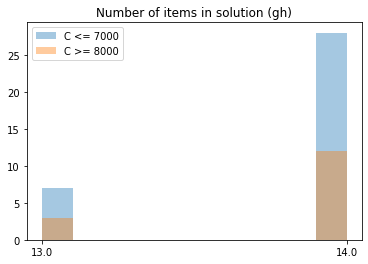

In [56]:
import statistics

df = data_Cs.sol_df

# df = data_Cs.inst_df

# sns.distplot(df[(df["C"] <= 7000)]["max_value"], kde=False)
# sns.distplot(df[(df["C"] >= 8000)]["max_value"], kde=False)


# df
# df[(df["method"] == "gh")]

# sns.distplot(df[(df["method"] == "gh") & (df["C"] <= 7000)]["max_value"], kde=False)
# sns.distplot(df[(df["method"] == "gh") & (df["C"] >= 8000)]["max_value"], kde=False)

# arr_1000 = []
# for l in df[(df["method"] == "redux") & (df["C"] == 1000) ]["solution"].values:
#     arr_1000.append(sum(l))
# sns.distplot(arr_1000, kde=False)


# arr_6000 = []
# for l in df[(df["method"] == "redux") & (df["C"] == 6000) ]["solution"].values:
#     arr_6000.append(sum(l))
# sns.distplot(arr_6000, kde=False)


arr_7000 = []
for l in df[(df["method"] == "gh") & (df["C"] <= 7000) ]["solution"].values:
    arr_7000.append(sum(l))


ax = sns.distplot(arr_7000,bins=10, kde=False, label="C <= 7000")

xticks = list(set(arr_7000))


arr_8000 = []
for l in df[(df["method"] == "gh") & (df["C"] >= 8000) ]["solution"].values:
    arr_8000.append(sum(l))

ax = sns.distplot(arr_8000,bins=10, kde=False, label="C >= 8000", ax=ax)


xticks.extend(list(set(arr_8000)))
xticks = list(set(xticks))
ax.set(xticks=xticks, xticklabels=xticks)
ax.set_title("Number of items in solution (gh)")
plt.legend()

plt.savefig(f"{data_Cs.figures_path}/number_of_items_in_solution_gh.png")


# arr_9000 = []
# for l in df[(df["method"] == "redux") & (df["C"] == 9000) ]["solution"].values:
#     arr_9000.append(sum(l))

# sns.distplot(arr_9000, kde=False)


# arr_10000 = []
# for l in df[(df["method"] == "redux") & (df["C"] == 10000) ]["solution"].values:
#     arr_10000.append(sum(l))

# sns.distplot(arr_10000, kde=False)


# arr_8000

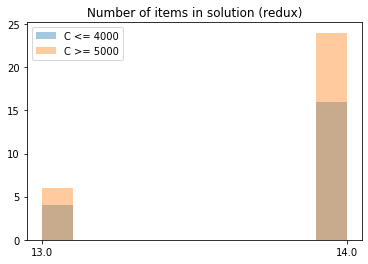

In [57]:
arr_7000 = []
for l in df[(df["method"] == "redux") & (df["C"] <= 4000) ]["solution"].values:
    arr_7000.append(sum(l))
    
ax = sns.distplot(arr_7000, bins=10, kde=False, label="C <= 4000")
xticks = list(set(arr_7000))

arr_8000 = []
for l in df[(df["method"] == "redux") & (df["C"] >= 5000) ]["solution"].values:
    arr_8000.append(sum(l))

ax = sns.distplot(arr_8000, bins=10, kde=False, label="C >= 5000", ax=ax)
ax.set_title("Number of items in solution (redux)")

xticks.extend(list(set(arr_8000)))
xticks = list(set(xticks))
ax.set(xticks=xticks, xticklabels=xticks)

plt.legend()

plt.savefig(f"{data_Cs.figures_path}/number_of_items_in_solution_redux.png")

# arr_8000
# arr_7000

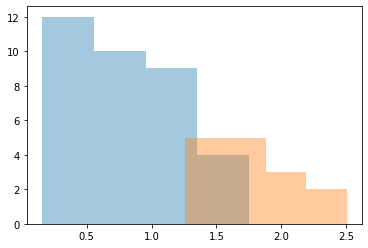

In [58]:
import statistics

df = data_Cs.inst_df

arr_7000 = []
for l in df[(df["C"] <= 7000) ][["weights", "values"]].values:
    arr_7000.append(statistics.mean(l[1]) / statistics.mean(l[0]))

sns.distplot(arr_7000, kde=False)

arr_8000 = []
for l in df[(df["C"] >= 8000) ][["weights", "values"]].values:
    arr_8000.append(statistics.mean(l[1]) / statistics.mean(l[0]))
sns.distplot(arr_8000, kde=False)


# arr_7000 = []
# for l in df[(df["C"] <= 7000) ]["values"].values:
#     arr_7000.extend(l)
    
# sns.distplot(arr_7000, kde=False)

# arr_8000 = []
# for l in df[(df["C"] >= 8000) ]["values"].values:
#     arr_8000.extend(l)

# sns.distplot(arr_8000, kde=False)


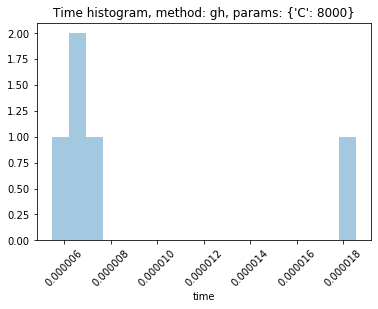

In [59]:
data_Cs.seeTimeHistogram(method="gh", C=8000)

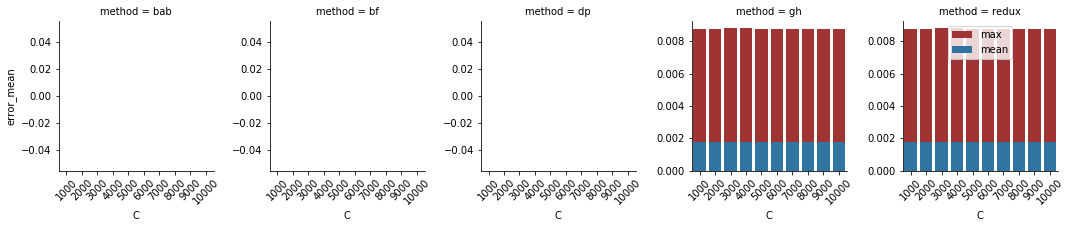

In [60]:
data_Cs.seeErrorBarplot()

## Permutations

In [61]:
data_ps = ParamTest(["p"], path=f"{DATA_PATH}/ps", values=PS_VALUES)

FileNotFoundError: [Errno 2] File ../data/ps/p_0_inst.csv does not exist: '../data/ps/p_0_inst.csv'

In [ ]:
data_ps.seeTimeBarplot()

In [ ]:
df = data_ps.sol_df

df[df["method"] == "bab"]

# axes[0].set_title(f"Capacity distribution")
sns.boxplot(x="p", y="time", data=df[df["method"] == "bab"])

plt.show()
sns.boxplot(x="p", y="time", data=df[df["method"] == "bf"])

In [ ]:
data_ps.seeBoxplotFull("time")

In [ ]:
data_ps.seeHistogram(method="dp", feature="time", p=0)

In [ ]:
data_ps.seeErrorBarplot()

In [ ]:
data_ps.seeBoxplotFull("error")

## Others and Tests

In [ ]:
# df = data_ms.sol_df

# sns.boxplot(y="m", x="time", orient="h" ,data=df[(df["method"] == "bf") & (df["m"] == 0.1)])

In [ ]:
# self = data_ks

# for p in product(*[self.params[-1:], self.methods.values(), *self.values, [self.sol_suffix]]):
#     sol_file = f"{self.path}/{'_'.join([str(i) for i in p])}"
# #             print(sol_file)
#     params_len = len(self.params)
#     kwargs = dict(zip(["method", *self.params], p[1 : (1+1+len(self.values))]))
#     print("kwargs: ", kwargs)
#     self.appendSolDataframe(sol_file, **kwargs)


In [ ]:
# data_ks
# self = data_ks


# for p in product(*[self.params[-1:], *self.values, [self.inst_suffix]]):
#     inst_file = f"{self.path}/{'_'.join([str(i) for i in p])}"
#     print(inst_file)
#     params_len = len(self.params)
#     kwargs = dict(zip(self.params, p[1 : (1+len(self.values))]))
#     print("kwargs: ", kwargs)
# #     self.appendInstDataframe(inst_file, **kwargs)


In [ ]:
# df = data_ks.sol_df

# df
# def calculate(max_value, computed_value):
# #             print("max value", max_value, "computed_value", computed_value)
#     difference = abs(max_value - computed_value)
#     max_value = max(max_value, computed_value)
#     assert(difference == 0 or max_value > 0), f"difference = {difference} and max_value = {max_value}"
#     rel_error = difference/max_value if (max_value > 0) else 0
#     return rel_error            
        
#         id_filter = (self.inst_df["ID"] == x["ID"])
#         param_filter = (self.inst_df[self.params[0]] == x[self.params[0]])
        
# self.sol_df["error"] = self.sol_df.apply(lambda x: 
#     calculate(self.inst_df[
#         (self.inst_df["ID"] == x["ID"]) & (self.inst_df[self.params[-1]] == x[self.params[-1]])
#     ]["max_value"].values[0], x["max_value"]), axis=1)



# df = df[[*self.params, "method", "time", "error"]].groupby(["method", *self.params])
# df = df.agg(['mean', 'max'])
# df.columns = df.columns.to_flat_index()

# df.columns = [f"{col[0]}_{col[1]}" for col in df.columns]

# df = df["method"].unstack()

# df = df.stack()

# df = df.reset_index()

# df["level_2"].unstack()
# df = df.rename(columns={"level_2": "aggregation"})
# df

In [ ]:
# Ws = dataset("W", "Ws", Ws_values)

In [ ]:
# Ws.getFigures()

In [ ]:
# Ws.seeFigures("time")

In [ ]:
# Ws.seeFigures("error")

## more light or heavy items, or balanced

In [ ]:
# ws = dataset("w", "ws", ws_values)

In [ ]:
# ws.getFigures()

In [ ]:
# ws.seeFigures("time")

In [ ]:
# ws.seeFigures("error")

In [ ]:
# Cs = dataset("C", "Cs", Cs_values)

In [ ]:
# Cs.getFigures()

In [ ]:
# Cs.seeFigures("time")

In [ ]:
# Cs.seeFigures("error")

## weigth and value correlation

In [ ]:
# # max(data_ns.inst_df["max_value"], data_ns.inst_df["max_value"])
# data_ns.sol_df
# # data_ns.sol_df.apply(lambda x: print("max_val", x["max_value"]), axis=1)

# # data_ns.sol_df.apply(lambda x: print("max_val", 
# #     data_ns.inst_df[(data_ns.inst_df["ID"] == x["ID"]) & (data_ns.inst_df["n"] == x["n"])]["max_value"].values[0]), axis=1)

# # data_ns.sol_df.apply(lambda x: print("x id", x["ID"]), axis=1)

# # data_ns.inst_df[(data_ns.inst_df["ID"] == 1) & (data_ns.inst_df["n"] == 1)]
# # sns.distplot(data_ns.sol_df["error"], kde=False)
# # sns.distplot(data_ns.sol_df[data_ns.sol_df["method"] == "gh"]["error"], kde=False)

# sns.distplot(data_ns.sol_df[
#     (data_ns.sol_df["method"] == "bf") & (data_ns.sol_df["n"] == "")
# ]["time"], kde=False)


In [ ]:
# cs = dataset("c", "cs", cs_values)

In [ ]:
# cs.dfs

In [ ]:
# cs.getFigures()

In [ ]:
# cs.seeFigures("time")

In [ ]:
# cs.seeFigures("error")

## granularity exponent

In [ ]:
# ks = dataset("k", "ks", ks_values)

In [ ]:
# # ks.analytic_df[ks.analytic_df["w"] != "heavy"]
# # ks.columns
# ks.seeFigures("time")

In [ ]:
# ks.seeFigures("error")

In [ ]:
            
#         value = f"{param}_{value}" if param != "" else value

#         self.dfs[f"{self.name}_{value}_inst"] =\
#                 getInstanceDataframe(f"{data_path}/{self.dataset}/{self.name}_{value}_inst.csv")
    


In [ ]:
# df = data_ns.sol_df

# df = df[["n", "method", "time", "error"]].groupby(["method", "n"]).max().stack().reset_index().rename(columns={"level_2": "column", 0: "max"})
# g = sns.FacetGrid(df, col="method", row="column", sharey=False)
# g.map(sns.barplot, "n", "max", color="firebrick") #, order=self.values)

# df = data_ns.sol_df

# df = df.groupby(["method", "n"]).mean().stack().reset_index().rename(columns={"level_2": "column", 0: "mean"})
# g = sns.FacetGrid(df, col="method", row="column", sharey=False)
# g.map(sns.barplot, "n", "mean", color="tab:blue") #, order=self.values)


In [ ]:
# df = data_ns.sol_df

# # df.groupby(["method"]).mean().unstack().plot.bar()
# # df.groupby(["method", "n"]).mean()["time"].unstack().plot.bar()
# # df.groupby(["method", "n"]).mean().unstack()["time"]
# # .unstack().plot.bar()
# # df

# # if self.name != "k":
# #     g = sns.FacetGrid(self.analytic_df, col="method", sharey=False)
# # else:
# #     g = sns.FacetGrid(self.analytic_df, col="method", row="w", sharex= False, sharey=False)

# # df.groupby(["method", "n"]).mean()["time"].unstack(level=0)
# # g = sns.FacetGrid(df.groupby(["method", "n"]).mean()["time"].unstack(level=0), sharey=False)

# # sns.barplot(df.groupby(["method", "n"]).mean()["time"].unstack(level=0), hue="method")

# # sns.barplot(df.groupby(["method", "n"]).mean(), hue="method")
# # df.groupby(["method", "n"])["time"].mean() #.index



# # df[["n", "method", "time", "error"]].groupby(["method", "n"]).max()

# df = df[["n", "method", "time", "error"]].groupby(["method", "n"]).max().stack().reset_index().rename(columns={"level_2": "column", 0: "max"})
# g = sns.FacetGrid(df, col="method", row="column", sharey=False)
# g.map(sns.barplot, "n", "max", color="firebrick") #, order=self.values)


# # g.map(sns.barplot, color="firebrick")
# # g.map(sns.barplot, color="firebrick")

# # df
# #["time"]
# # .mean().stack().reset_index()

# #.mean()["time"].index

# # fg = sns.factorplot(x='n', col='method', data=df.groupby(["method", "n"])["time"].mean(), kind='bar')

# # mediumModes = df.groupby(DEP)[MED].apply(lambda x: x.mode())
# # ["time"].mean()

# #.unstack(level=0)
# # df

# # g = sns.FacetGrid(df, col="method", row="column", sharey=False)
# # # g.map(sns.barplot, color="firebrick")
# # g.map(sns.barplot, "n", "mean", color="tab:blue") #, order=self.values)


In [ ]:

# df = data_ns.sol_df

# df = df[["n", "method", "time", "error"]].groupby(["method", "n"])
# df = df.agg(['mean', 'max'])
# # df.columns = df.columns.to_flat_index()
# df.columns = [f"{col[0]}_{col[1]}" for col in df.columns]
# # df = df["method"].unstack()

# # df = df.stack()
# df = df.reset_index()
# # df["level_2"].unstack()
# # df = df.rename(columns={"level_2": "aggregation"})


# df

# g = sns.FacetGrid(df, col="method", sharey=False)
# g.map(sns.barplot, "n", "time_max", color="firebrick") #, order=df[]self.values) #
# g.map(sns.barplot, "n", "time_mean", color="tab:blue") #, order=df[]self.values) #

# # g.map(sns.barplot, "n", "time", color="firebrick") #, order=self.values)
# # g.map(sns.barplot, "n", "mean", color="tab:blue") #, order=self.values)



# # df.index = df.index.to_flat_index()


# # df = df[["n", "method", "time", "error"]].groupby(["method", "n"]).max().stack().reset_index().rename(columns={"level_2": "column", 0: "max"})

In [ ]:


# class dataset:
#     methods={"1":"bf", "2":"bab", "3":"dp", "4":"gh", "5":"redux"}
    
#     def __init__(self, name, dataset, values):
#         self.name = name
#         self.dataset = dataset
#         self.values = values
#         self.targets = ["time", "error"]
#         if self.name != "k":
#             self.columns = [self.name, "mean_time", "max_time", "mean_error", "max_error", "method"]
#         else:
#             self.columns = [self.name, "w", "mean_time", "max_time", "mean_error", "max_error", "method"]

#         self.dfs = {}
#         self.analytic_df = None
#         self.getDataframe() if self.name != "k" else self.getDataframeKs()
#         self.getAnalyticDataframe() if self.name != "k" else self.getAnalyticDataframeKs()
        
#     def getDataframe(self, param=""):
#         for value in self.values:
#             value = f"{param}_{value}" if param != "" else value
#             self.dfs[f"{self.name}_{value}_inst"] =\
#                 getInstanceDataframe(f"{data_path}/{self.dataset}/{self.name}_{value}_inst.csv")
#             for num, met in self.methods.items():
#                 self.dfs[f"{self.name}_{met}_{value}"] =\
#                     getMethodResults(f"{data_path}/{self.dataset}/{self.name}_{met}_{value}_sol.csv")
#                 self.dfs[f"{self.name}_{met}_{value}"]["error"] =\
#                     self.dfs[f"{self.name}_{met}_{value}"][["ID","max_value"]].apply(
#                         lambda row: calculateRelativeError(self.dfs[f"{self.name}_bf_{value}"], row), axis=1
#                     )

#     def getDataframeKs(self):
#         for w in ["light", "heavy"]:
#             self.getDataframe(param=w)
            
#     def getAnalyticDataframeKs(self):
#         for w in ["light", "heavy"]:
#             self.getAnalyticDataframe(param=w)
        
                
#     def getAnalyticDataframe(self, param=""):
#         self.analytic_df = pd.DataFrame(columns=self.columns) if self.analytic_df is None else self.analytic_df
    
#         for value in self.values:
# #             value = f"{value}" if param != "" else value
#             param_value = f"{param}_{value}" if param != "" else value
#             for num, met in self.methods.items():
#                 if param == "":
#                     row = {self.name: [value], "method": [met]}
#                 else:
#                     row = {self.name: [value], "method": [met], "w": param}
#                 for target in self.targets:
#                     row[f"mean_{target}"] = [self.dfs[f"{self.name}_{met}_{param_value}"][target].mean()]
#                     row[f"max_{target}"] = [self.dfs[f"{self.name}_{met}_{param_value}"][target].max()]
                
#                 self.analytic_df = pd.concat([
#                     self.analytic_df,
#                     pd.DataFrame(row, columns=self.columns)
#                 ])
#         self.analytic_df["max_error"] = pd.to_numeric(self.analytic_df["max_error"])
        
#     def seeFigures(self, feature):
#         if self.name != "k":
#             g = sns.FacetGrid(self.analytic_df, col="method", sharey=False)
#         else:
#             g = sns.FacetGrid(self.analytic_df, col="method", row="w", sharex= False, sharey=False)
#         g.map(sns.barplot, self.name, f"max_{feature}", color="firebrick", order=self.values)
#         g.map(sns.barplot, self.name, f"mean_{feature}", color="tab:blue", order=self.values)
        
# #         if (len(str(self.values[-1])) > 2):
# #             for ax in g.axes.flat:
# #                 for label in ax.get_xticklabels():
# #                     label.set_rotation(70)
    
# #         if self.name != "k":
# #             g = sns.FacetGrid(self.analytic_df, col="method", sharey=False)
# #         else:
# #             g = sns.FacetGrid(self.analytic_df, col="method", row="w", sharex= False, sharey=False)
# #         g.map(sns.barplot, self.name, f"max_{feature}", color="firebrick", order=self.values)
        
#         if (len(str(self.values[-1])) > 2) or True:
#             for ax in g.axes.flat:
#                 for label in ax.get_xticklabels():
#                     label.set_rotation(45)
#         g.savefig(f"{figures_path}/{self.name}_{feature}.png")


# #         g.set(xticks=self.analytic_df[self.name].unique(), rotation=70)
# #         plt.xticks(rotation=<200c><200b>45)
# #         plt.xticks(rotation=70)
# #         methods_num = len(self.methods)
# #         xticks = 
    
# #         fig, axes = plt.subplots(nrows=methods_num, ncols=2)
# #         fig.set_size_inches(10, 14)
        
# #         for idx, (num, met) in enumerate(self.methods.items()):
# #             sns.lineplot(x=self.name, y=f"mean_{feature}", hue=hue, style=style,
# #                 data=self.analytic_df[self.analytic_df["method"] == met], 
# #                 ax=axes[idx][0], legend="full", dashes=dashes).set_title(f"Mean {title}")
# #             axes[idx][0].set(xticks=xticks, xticklabels=xticks)

# #         for idx, (num, met) in enumerate(self.methods.items()):
# #             sns.lineplot(x=self.name, y=f"max_{feature}", hue=hue, style=style,
# #                 data=self.analytic_df[self.analytic_df["method"] == met], 
# #                 ax=axes[idx][1], legend="full", dashes=dashes).set_title(f"Maximum {title}")
# #             axes[idx][1].set(xticks=xticks, xticklabels=xticks)




        
                
#     def getFigures(self):
#         visualizeMeanAndMax(self.analytic_df, x=self.name, feature="time", hue="method", style="method", title="time (in seconds) consumed")
#         visualizeMeanAndMax(self.analytic_df, x=self.name, feature="error", hue="method", style="method", title="relative error")


## Helper functions

- load dataframes
- calculate error

In [ ]:
# dash_styles = ["",
#                (4, 1.5),
#                (1, 1),
#                (3, 1, 1.5, 1),
#                (5, 1, 1, 1),
#                (5, 1, 2, 1, 2, 1),
#                (2, 2, 3, 1.5),
#                (1, 2.5, 3, 1.2)]

# # sns.relplot(...,  dashes=dash_styles,...)

# def visualizeMeanAndMax(df, x, feature, hue, style=None, title="", dashes=dash_styles):
#     xticks = df[x].unique()
    
#     fig, axes = plt.subplots(nrows=1, ncols=2)
#     fig.set_size_inches(12, 6)
        
#     g = sns.lineplot(x=x, y=f"mean_{feature}", hue=hue, style=style, data=df, 
#         ax=axes[0], legend="full", dashes=dashes).set_title(f"Mean {title}")
#     axes[0].set(xticks=xticks, xticklabels=xticks)
        
#     g = sns.lineplot(x=x, y=f"max_{feature}", hue=hue, style=style, data=df,
#         ax=axes[1], legend="full", dashes=dashes).set_title(f"Maximum {title}")
#     axes[1].set(xticks=xticks, xticklabels=xticks)

#     fig.savefig(f"{figures_path}/{x}_{feature}_{hue}.png")



# # def visualizeMeanAndMax(df, feature, hue, style=None, title="", dashes=dash_styles):
# #     for ds in dataset:
# #         xticks = df[ds]["n"].unique()
    
# #         fig, axes = plt.subplots(nrows=1, ncols=2)
# #         fig.set_size_inches(12, 6)
        
# #         g = sns.lineplot(x="n", y=f"mean_{feature}", hue=hue, style=style, data=df[ds], 
# #             ax=axes[0], legend="full", dashes=dashes).set_title(f"Mean {title} [{ds.upper()}]")
# #         axes[0].set(xticks=xticks, xticklabels=xticks)
        
# #         sns.lineplot(x="n", y=f"max_{feature}", hue=hue, dashes=dashes, style=style, data=df[ds],
# #             ax=axes[1], legend="full").set_title(f"Maximum {title} [{ds.upper()}]")
# #         axes[1].set(xticks=xticks, xticklabels=xticks)

# #         fig.savefig(f"{figures_path}/{feature}_{ds}_{hue}.png")

In [ ]:
# feature = title = "error"
# hue = style = "method"
# dashes = dash_styles


# sns.lineplot(x="n", y=f"max_{feature}", hue=hue, style=style, data=ns.analytic_df,
#     legend="full", dashes=dashes).set_title(f"Maximum {title}")

# sns.lineplot(x="n", y=f"max_{feature}", data=ns.analytic_df)

# ns.analytic_df["n"]

# ns.analytic_df["mean_error"].describe()
# ns.analytic_df["max_error"].describe()
# ns.analytic_df["max_error"] = pd.to_numeric(ns.analytic_df["max_error"])
# sns.lineplot(x="n", y="max_error", data=ns.analytic_df)